In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [2]:
df = pd.read_csv("/kaggle/input/eece5645-project/ISIC_2019_Training_GroundTruth.csv")

In [3]:
df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
train_dir = "/kaggle/input/eece5645-project/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
df['image_path'] = df['image'].apply(lambda x: os.path.join(train_dir, f"{x}.jpg"))

In [6]:
df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,image_path
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/eece5645-project/ISIC_2019_Train...
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/eece5645-project/ISIC_2019_Train...
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/eece5645-project/ISIC_2019_Train...
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/eece5645-project/ISIC_2019_Train...
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/eece5645-project/ISIC_2019_Train...


In [7]:
classes = df.columns[1:-2].tolist()
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

In [8]:
labels = df.drop(columns=['image', 'UNK', 'image_path']).values.tolist()
image_paths = df['image_path'].tolist()

In [9]:
len(image_paths)
len(labels)

25331

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


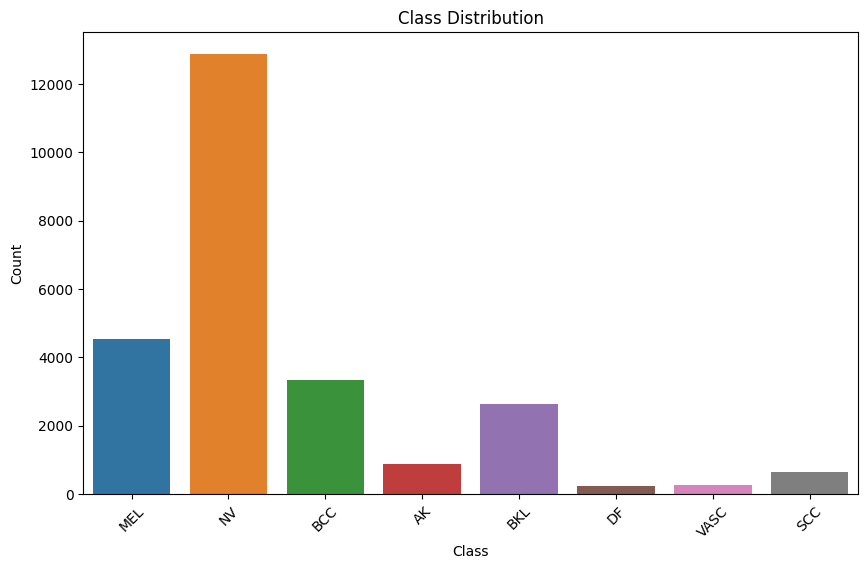

In [10]:
# Visualize the distribution of classes
class_counts = np.sum(labels, axis=0)
plt.figure(figsize=(10, 6))
sns.barplot(x=classes, y=class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [11]:
# Split data into training and test sets and convert labels
train_images, test_images, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [12]:
# Preprocessing functions
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [260, 260])  # Resize without 'nearest' mode
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    return image

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

def load_and_preprocess_from_path_labels(path, label):
    return load_and_preprocess_image(path), label

In [13]:
# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.map(load_and_preprocess_from_path_labels, num_parallel_calls=tf.data.AUTOTUNE)\
                   .map(data_augment, num_parallel_calls=tf.data.AUTOTUNE)\
                   .shuffle(2048).batch(32).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.map(load_and_preprocess_from_path_labels, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [14]:
# Define learning rate schedule
LR_START = 0.00001
LR_MAX = 0.00005 
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = 0.8
EPOCHS = 15

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [15]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(include_top=False, input_shape=(260, 260, 3), pooling='avg')
base_output = base_model.output
classifier = tf.keras.layers.Dense(len(classes), activation='softmax')(base_output)
model = tf.keras.Model(inputs=base_model.input, outputs=classifier)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [17]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [18]:
import time

In [19]:
start_time = time.time()

In [20]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[lr_callback],
)
end_time = time.time()
print(end_time - start_time)


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/15


I0000 00:00:1733282608.829261      95 service.cc:145] XLA service 0x79e400002460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733282608.829334      95 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733282634.856036      95 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1733282634.900866      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.5801 - loss: 1.2151

I0000 00:00:1733282791.460805      97 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_39', 52 bytes spill stores, 52 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 16 bytes spill stores, 16 bytes spill loads



634/634 ━━━━━━━━━━━━━━━━━━━━ 252s 295ms/step - accuracy: 0.5802 - loss: 1.2147 - val_accuracy: 0.1981 - val_loss: 3.8518 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 162s 245ms/step - accuracy: 0.7349 - loss: 0.7363 - val_accuracy: 0.7482 - val_loss: 0.6938 - learning_rate: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 3.0000000000000004e-05.
Epoch 3/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 161s 244ms/step - accuracy: 0.8083 - loss: 0.5324 - val_accuracy: 0.7723 - val_loss: 0.6675 - learning_rate: 3.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 4e-05.
Epoch 4/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 161s 244ms/step - accuracy: 0.8746 - loss: 0.3660 - val_accuracy: 0.7732 - val_loss: 0.7008 - learning_rate: 4.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 5e-05.
Epoch 5/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 161s 245ms/step - accuracy: 0.8994 - loss: 0.2906 - val_ac

In [21]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 260, 260,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 266, 266,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 130, 130,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 130, 130,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 130, 130,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 132, 132,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 65, 65,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 65, 65,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 65, 65,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 65, 65,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 65, 65,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 65, 65,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 65, 65,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 65, 65,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 65, 65,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 65, 65,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 65, 65,    │      1,024 │ conv2_block1_3_c

 Total params: 70,706,074 (269.72 MB)

 Trainable params: 23,550,984 (89.84 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 47,101,970 (179.68 MB)

In [22]:
# Evaluate model performance
y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(model.predict(test_ds), axis=1)

159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step


In [23]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8284981251233472
Precision: 0.7833229297796822
Recall: 0.7020885813568613
Confusion Matrix:
 [[ 632  181   33    7   51    0    0   11]
 [  78 2396   23    5   58    2    1    4]
 [  20   51  545   12   15    0    1   14]
 [   9    6   27   94   17    0    0   24]
 [  25   76   17   13  391    0    0   14]
 [   3    8    8    0    3   23    1    2]
 [   2    6    5    0    2    1   46    0]
 [   4    6   16    1    6    0    0   71]]


In [24]:
# Print the number of images belonging to each label in training data
print("Training Class Distribution:")
print(df.drop(columns=['image', 'UNK', 'image_path']).sum())

# Print the number of images belonging to each label in test data
print("Test Class Distribution:")
test_data = pd.DataFrame({'image': test_images, 'label': test_labels})
print(test_data['label'].value_counts())

# Class index to name mapping
class_index_to_name = {idx: cls for cls, idx in class_to_idx.items()}
print("Class Index to Name Mapping:")
print(class_index_to_name)

Training Class Distribution:
MEL      4522.0
NV      12875.0
BCC      3323.0
AK        867.0
BKL      2624.0
DF        239.0
VASC      253.0
SCC       628.0
dtype: float64
Test Class Distribution:
label
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    2567
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]     915
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]     658
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]     536
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]     177
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]     104
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]      62
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]      48
Name: count, dtype: int64
Class Index to Name Mapping:
{0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AK', 4: 'BKL', 5: 'DF', 6: 'VASC', 7: 'SCC'}


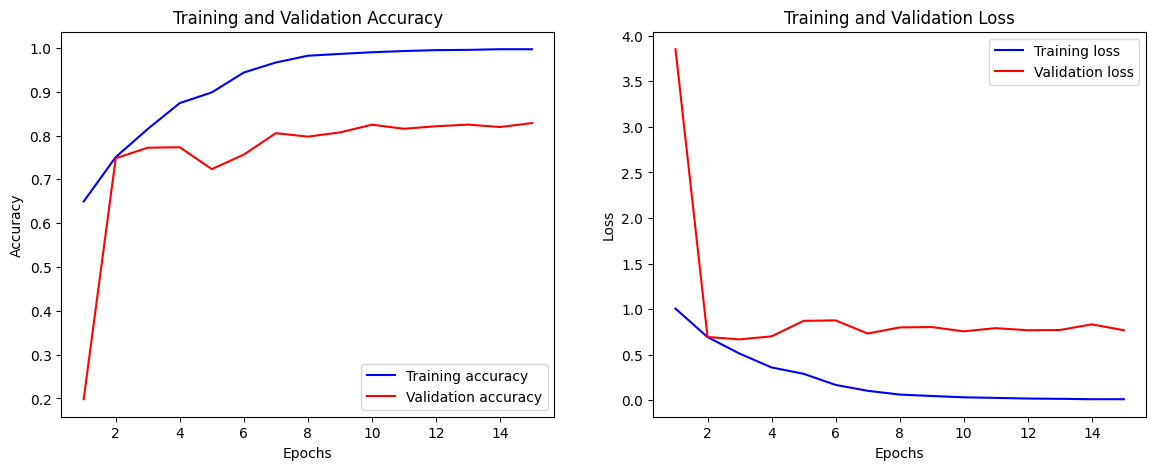

159/159 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step
Accuracy: 0.8284981251233472
Precision: 0.7833229297796822
Recall: 0.7020885813568613
Confusion Matrix:
 [[ 632  181   33    7   51    0    0   11]
 [  78 2396   23    5   58    2    1    4]
 [  20   51  545   12   15    0    1   14]
 [   9    6   27   94   17    0    0   24]
 [  25   76   17   13  391    0    0   14]
 [   3    8    8    0    3   23    1    2]
 [   2    6    5    0    2    1   46    0]
 [   4    6   16    1    6    0    0   71]]


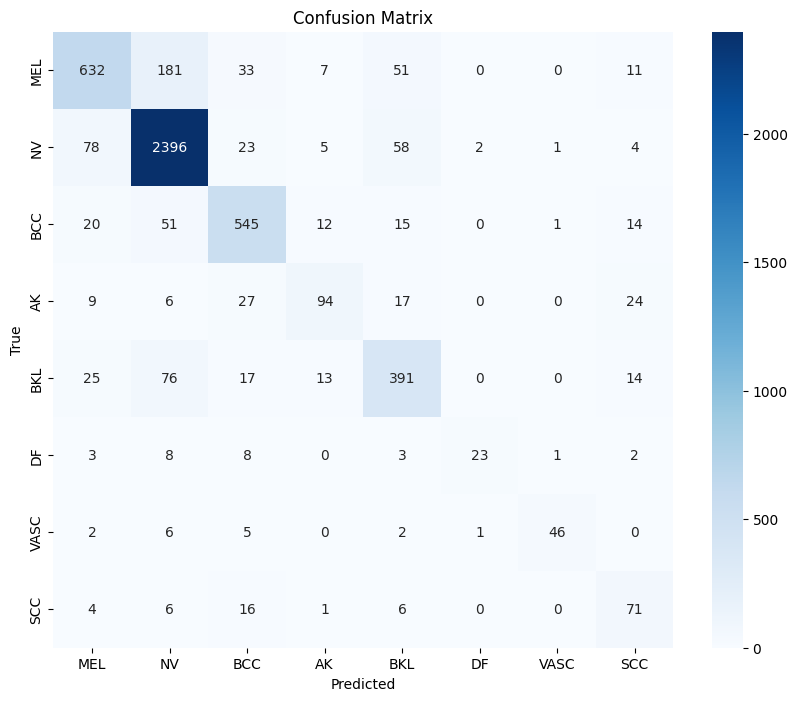

Training Class Distribution:
MEL                                                      4522.0
NV                                                      12875.0
BCC                                                      3323.0
AK                                                        867.0
BKL                                                      2624.0
DF                                                        239.0
VASC                                                      253.0
SCC                                                       628.0
image_path    /kaggle/input/eece5645-project/ISIC_2019_Train...
dtype: object
Test Class Distribution:
label
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    2567
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]     915
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]     658
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]     536
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]     177
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]     104
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]      62
[0.0, 0

In [26]:
# Plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_training_history(history)

# Evaluate model performance
y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(model.predict(test_ds), axis=1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_true, y_pred, classes)

# Print the number of images belonging to each label in training data
print("Training Class Distribution:")
print(df.drop(columns=['image', 'UNK']).sum())

# Print the number of images belonging to each label in test data
print("Test Class Distribution:")
test_data = pd.DataFrame({'image': test_images, 'label': test_labels})
print(test_data['label'].value_counts())

# Class index to name mapping
class_index_to_name = {idx: cls for cls, idx in class_to_idx.items()}
print("Class Index to Name Mapping:")
print(class_index_to_name)
